In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from scipy.stats import loguniform, beta, uniform
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline
import missingno as msno
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix

from sklearn.decomposition import TruncatedSVD
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
X = pd.read_csv("data/crime.csv", delimiter=";")
X

,Record.ID,Agency.Code,Agency.Name,Agency.Type,City,State,Month.Year,Year,Month.Number,Month,...,Victim.Ethnicity,Perpetrator.Sex,Perpetrator.Age,Perpetrator.Race,Perpetrator.Ethnicity,Relationship,Weapon,Victim.Count,Perpetrator.Count,Record.Source
0,536745,FL00100,Alachua County,Sheriff,Orange,Florida,01/04/2008,2008,4,April,...,NaN,Male,65.0,White,NaN,No_relationship,Blunt Object,0,0,FOIA
1,536746,FL00101,Gainesville,Municipal Police,Orange,Florida,01/03/2008,2008,3,March,...,NaN,Male,43.0,White,NaN,No_relationship,Firearm,0,0,FOIA
2,536747,FL00101,Gainesville,Municipal Police,Orange,Florida,01/05/2008,2008,5,May,...,NaN,Male,23.0,Black,NaN,No_relationship,Knife,0,0,FOIA
3,536748,FL00101,Gainesville,Municipal Police,Orange,Florida,01/11/2008,2008,11,November,...,NaN,Male,16.0,Black,NaN,No_relationship,Knife,0,0,FOIA
4,536749,FL00200,Dade County,Sheriff,Dade,Florida,01/03/2008,2008,3,March,...,NaN,Female,40.0,White,NaN,Husband,Firearm,0,0,FOIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,538036,FL06402,Deland,Municipal Police,Orange,Florida,01/08/2008,2008,8,August,...,NaN,NaN,NaN,NaN,NaN,No_relationship,Knife,0,0,FOIA
1292,538037,FL06402,Deland,Municipal Police,Orange,Florida,01/09/2008,2008,9,September,...,NaN,Male,22.0,Black,NaN,No_relationship,Firearm,0,0,FOIA
1293,538038,FL06406,Edgewater,Municipal Police,Orange,Florida,01/04/2008,2008,4,April,...,NaN,NaN,NaN,NaN,NaN,No_relationship,NaN,0,0,FOIA
1294,538039,FL06600,Walton County,Sheriff,Dade,Florida,01/11/2008,2008,11,November,...,NaN,Male,27.0,White,NaN,No_relationship,Handgun,0,0,FOIA


In [3]:
y= X.pop('Crime.Solved').map({'VERO':1, 'FALSO':0}).values

<AxesSubplot:>

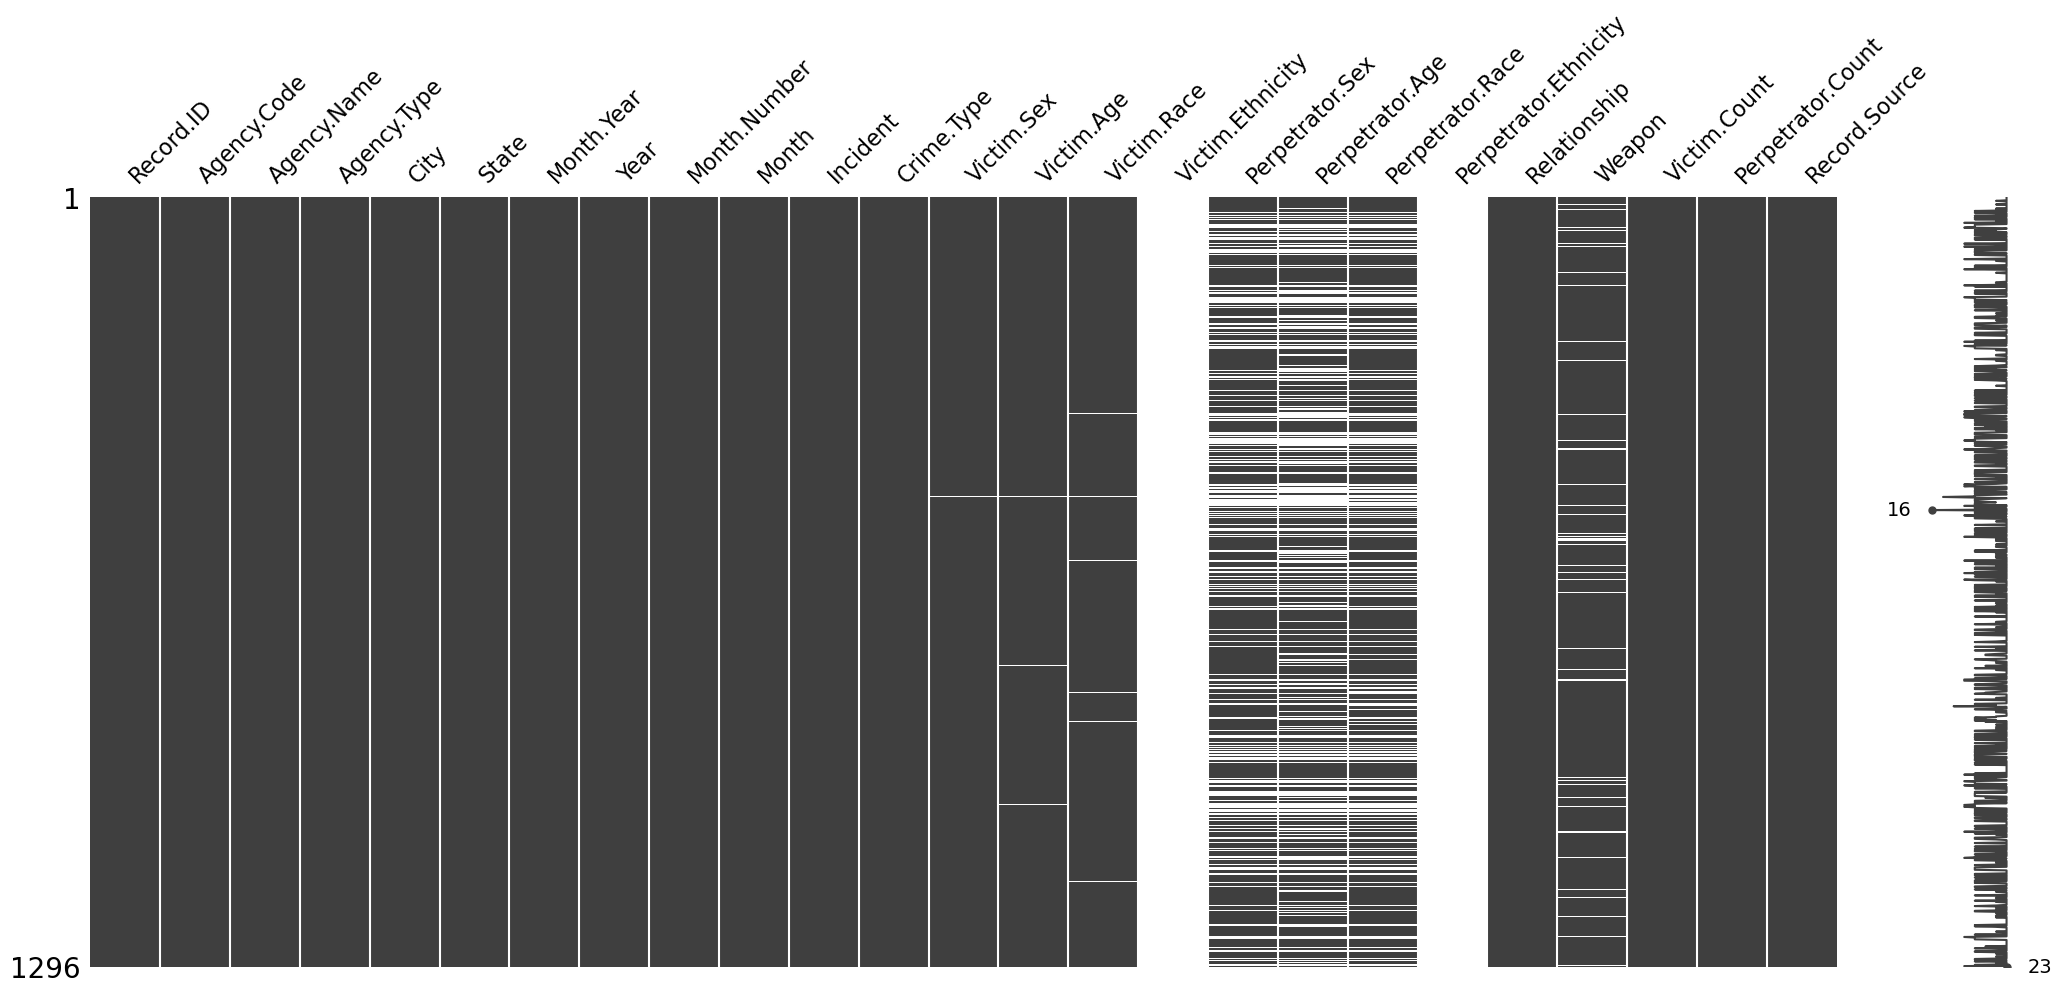

In [4]:
msno.matrix(X)

> Creation of the Pipeline

I created just two pipelines since it was sufficient one for the categorical values and one for the numerical ones. The choiche of the KNN instead of the simple imputer is due to the fact that i wanted to take an imputer that was more precise

In [5]:
pipeline_num = Pipeline([
    ('imp', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])
pipeline_cat = Pipeline([
    ('1', SimpleImputer(strategy="most_frequent")),
    ('2', OneHotEncoder(drop="first", categories="auto", handle_unknown = 'ignore'))
])

> Final transformation

In [6]:
final_transformation = ColumnTransformer([
    ("1", pipeline_num, [ "Victim.Age", "Perpetrator.Age"]),
    ("2", pipeline_cat, [ "Agency.Type", "Crime.Type", "Victim.Sex", "Victim.Race", "Perpetrator.Sex","Perpetrator.Race", "City", "Weapon", "Relationship", "Month", "Victim.Count"])
],
remainder="drop",
verbose_feature_names_out=True,
sparse_threshold=0
)



In [7]:
X_transformed = pd.DataFrame(final_transformation.fit_transform(X))
X_transformed

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.619565,0.701299,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.543478,0.415584,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.250000,0.155844,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.228261,0.064935,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.500000,0.376623,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,0.293478,0.210390,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1292,0.228261,0.142857,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1293,0.000000,0.155844,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,0.434783,0.207792,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


> Split the dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle= True, stratify= y)

> First try with a "trivial" pipeline

In [9]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
    
])

In [95]:
from sklearn import set_config
set_config(display="diagram")
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('1',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Victim.Age',
                                                   'Perpetrator.Age']),
                                                 ('2',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Agency.Type', 'Crime.Type',
                                                   'Victim.Sex', 'Victim.Race',
                                                   'Perpetrator.Sex',
                                                   'Perpetrator.Race', 'City',
                                                   'Weapon', 'Relationship',
                                                   'Month',
                                                   'Victim.Count'])])),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [11]:
f1_score(y_test, model_pipeline.predict(X_test))

0.8056338028169014

In [12]:
model_pipeline.predict(X_test)

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

> Composition of all the configurations in order to find the best pipeline

In [13]:
sampler_configs= [
    {
        'sampler': [None],
    },
    {
        'sampler': [SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy': ['minority', 1.1, 0.9, 0.8]
    },
    {
        'sampler': [RandomOverSampler()],
        'sampler__sampling_strategy': ['minority', 1.1, 0.9, 0.8]
    }
]

In [14]:
dim_reduction_configs = [
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.6, 0.7, 0.8, 0.9]
    },
    { 
        'dim_reduction': [LDA()]
    },
    {
    'dim_reduction': [TruncatedSVD()],
    'dim_reduction__n_components': [5, 10, 20, 30]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv=None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features': [15, 20]
    }
]

In [15]:
classifier_configs = [
    {
        'classifier__eta0': loguniform(0.01, 1),
        'classifier': [Perceptron()],
        'classifier__max_iter': [1, 5, 10, 20],
        'classifier__class_weight': [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')], 
        'classifier__C': loguniform(0.001, 100),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100, 500, 1000]
    },

    {
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': [10, 50, 100, 500],
    'classifier__max_depth': [2, 4, 8]
    }
]

In [16]:
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs)]

In [17]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 48'

> Randomized Search in order to find the best configuration

In [18]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs)*5,
    n_jobs= -1,
    cv = 2,
    scoring= 'f1',
    random_state = 42, 
    verbose=1

)
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv=2, return_estimator=True, verbose= 3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 240 candidates, totalling 480 fits
[CV] END ......................................., score=0.926 total time=  19.3s
Fitting 2 folds for each of 240 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s remaining:    0.0s


[CV] END ......................................., score=0.860 total time=  14.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.5s finished


In [19]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)
    print(" ")

RandomOverSampler(sampling_strategy='minority')
SequentialFeatureSelector(cv=None, estimator=Perceptron(), k_features=(20, 20),
                          scoring='f1')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'bo

In [20]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set: {f1_train}, F1 on test set: {f1_test}, Difference of F1 on train and test set: {f1_train - f1_test}')

F1 on training set: 0.9925220938137321, F1 on test set: 0.9090909090909092, Difference of F1 on train and test set: 0.08343118472282296
F1 on training set: 0.9738651994497937, F1 on test set: 0.8925619834710744, Difference of F1 on train and test set: 0.08130321597871926


> 1)LDA+RandomForest

In [21]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction',  LDA()),
    ('classifier', RandomForestClassifier())
])

params= {
    'classifier__n_estimators': [50, 75, 100, 200, 300],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced']
}

rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1',
    random_state=33,
    n_jobs=-1,
    error_score='raise',
    verbose=1
)

In [22]:
rs_best.fit(X_train, y_train)
y_pred = rs_best.predict(X_test)
#f1_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {rs_best.best_score_}")
print(f"Best parameters: {rs_best.best_params_}")
print(f"F1 score on test set: {f1_score}")

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Best F1 score: 0.8273678855518583
Best parameters: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'auto', 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__class_weight': None}
F1 score on test set: <function f1_score at 0x000001EC03F4E0D0>


In [23]:
rs_best.fit(X_train, y_train)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('1',
                                                                               Pipeline(steps=[('imp',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Victim.Age',
                                                                                'Perpetrator.Age']),
                

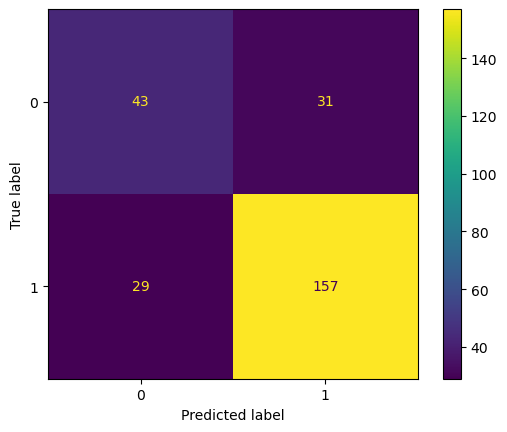

In [24]:
plot_confusion_matrix(rs_best, X_test, y_test)
plt.show()

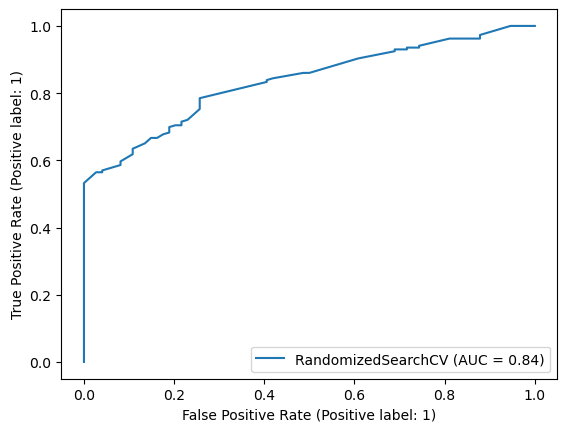

In [25]:
plot_roc_curve(rs_best, X_test, y_test)
plt.show()

In [26]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('1',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Victim.Age',
                                                   'Perpetrator.Age']),
                                                 ('2',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('2',
                                                                   OneHotEncoder(drop='first',
     

In [27]:
cls = rs_best.best_estimator_

In [28]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 2,
                                                       n_jobs = -1,
                                                       shuffle = True, 
                                                       scoring = 'f1',
                                                       verbose = 1 
                                        )

[learning_curve] Training set sizes: [  5  51 103 155 207 259 310 362 414 466 518]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.2s finished


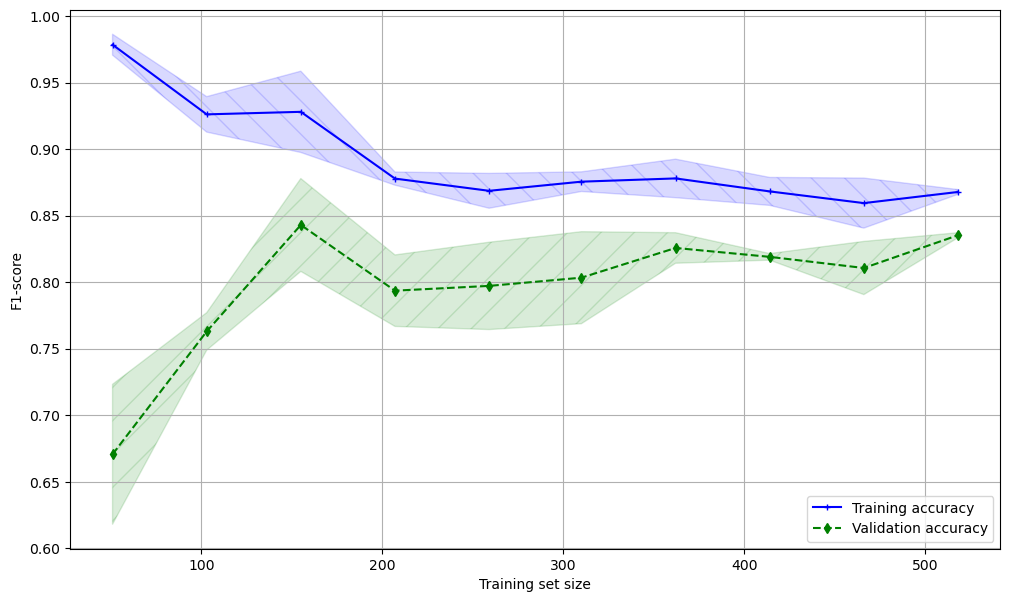

In [29]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axA = fig.add_subplot()

axA.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

axA.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue', 
                 hatch='\\')

axA.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

axA.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axA.grid()
axA.set_xlabel('Training set size')
axA.set_ylabel('F1-score')
axA.legend(loc='lower right')
axA.set_autoscale_on(True)

In [30]:
range_classifier = [50, 75, 100, 200, 300]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=range_classifier, 
        param_name='classifier__n_estimators',
        cv=5, 
        n_jobs=-1, 
        scoring='f1',
        error_score= 'raise',
        verbose=1 
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished


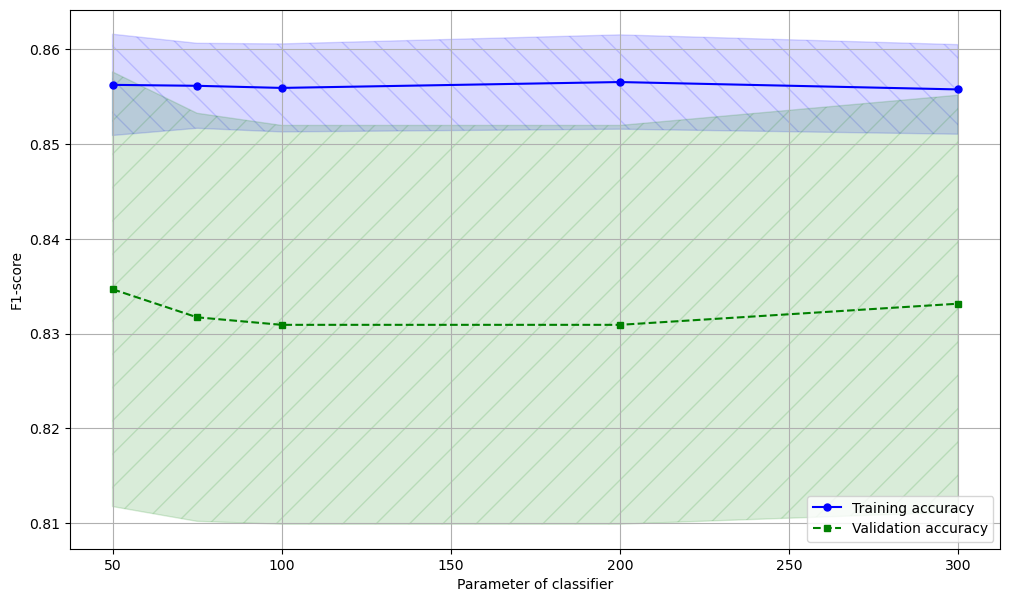

In [31]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axB = fig.add_subplot()
axB.plot(range_classifier, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

axB.fill_between(range_classifier,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue',
                 hatch='\\')

axB.plot(range_classifier, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

axB.fill_between(range_classifier,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axB.grid()
axB.set_xlabel('Parameter of classifier')
axB.set_ylabel('F1-score')
axB.legend(loc='lower right')
axB.set_autoscale_on(True)

> 2)SFS+XGBClassifier

In [32]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction', SFS(LogisticRegression(), k_features=(20, 20), scoring='f1')),
    ('classifier', XGBClassifier())
])

params = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.01, 0.1],
    'dim_reduction__k_features': [5, 10, 15],
    'dim_reduction__forward': [True, False],
}

rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1',
    random_state=33,
    n_jobs=-1,
    verbose=1
)

In [33]:
rs_best.fit(X_train, y_train)
y_pred = rs_best.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"Best F1 score: {rs_best.best_score_}")
print(f"Best parameters: {rs_best.best_params_}")
print(f"F1 score on test set: {f1}")

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Best F1 score: 0.9051957910020565
Best parameters: {'dim_reduction__k_features': 15, 'dim_reduction__forward': False, 'classifier__n_estimators': 100, 'classifier__learning_rate': 0.1}
F1 score on test set: 0.9115281501340482


In [34]:
rs_best.fit(X_train, y_train)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('1',
                                                                               Pipeline(steps=[('imp',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Victim.Age',
                                                                                'Perpetrator.Age']),
                                                        

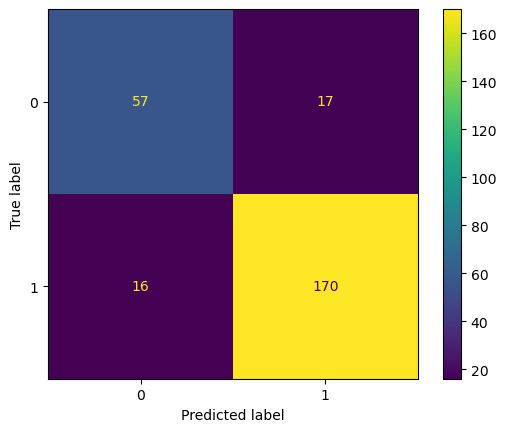

In [35]:
plot_confusion_matrix(rs_best, X_test, y_test)
plt.show()

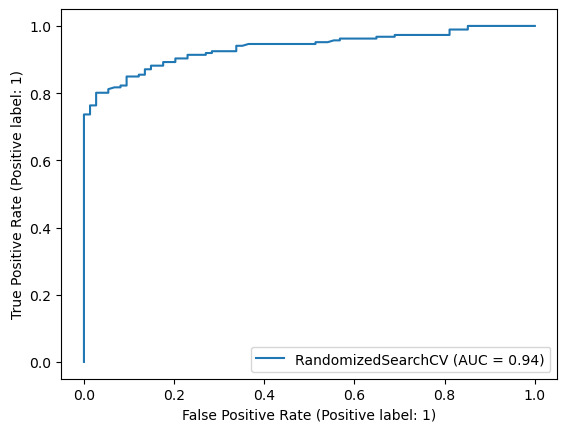

In [36]:
plot_roc_curve(rs_best, X_test, y_test)
plt.show()


In [96]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('1',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Victim.Age',
                                                   'Perpetrator.Age']),
                                                 ('2',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Agency.Type', 'Crime.Type',
                                                   'Victim.Sex', 'Victim.Race',
                                                   'Perpetrator.Sex',
                                                   'Perpetrator.Race', 'City',
                                                   'Weapon', 'Relationship',
                                                   'Month',
                                                   'Victim.Count'])])),
                ('smote', SMOTE(random_state=42)),
                ('dim_reduction',
                 SequentialFeatureSelector(estimator=Perceptron(),
                                           k_features=(20, 20), scoring='f1')),
                ('classifier',
                 Perceptron(class_weight='balanced', eta0=0.015954298869143627,
                            max_iter=20))])

In [38]:
cls= rs_best.best_estimator_

In [39]:
train_sizes, train_scores, test_scores = learning_curve(
    cls,
    X=X_train,
    y=y_train,
    train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=2,
    n_jobs=-1,
    shuffle=True,
    scoring='f1',
    verbose=1
)

[learning_curve] Training set sizes: [  5  51 103 155 207 259 310 362 414 466 518]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   43.6s finished


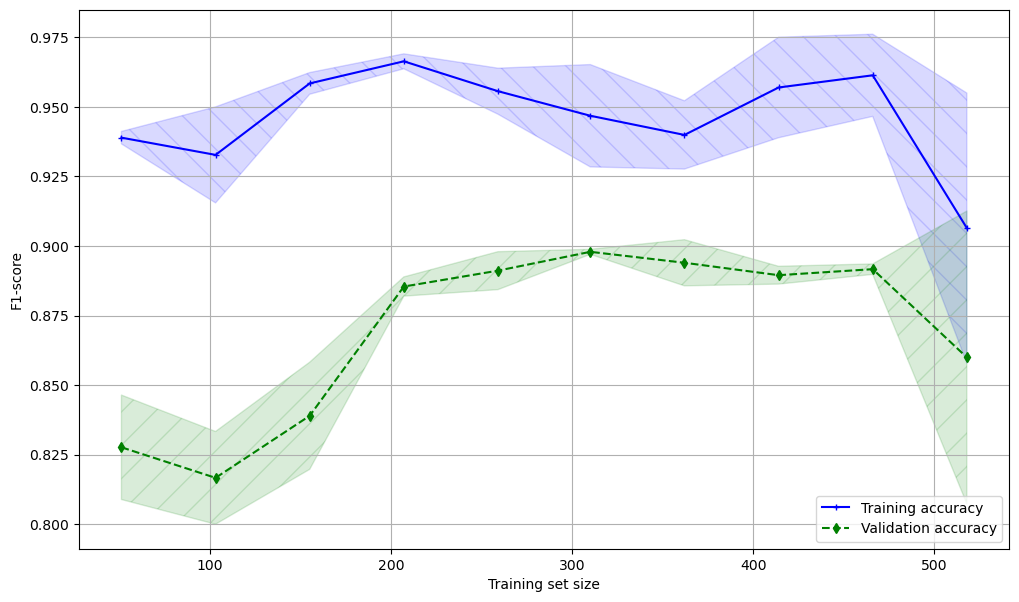

In [40]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axA = fig.add_subplot()

axA.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

axA.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue', 
                 hatch='\\')

axA.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

axA.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axA.grid()
axA.set_xlabel('Training set size')
axA.set_ylabel('F1-score')
axA.legend(loc='lower right')
axA.set_autoscale_on(True)

In [41]:
range_classifier = [50, 100]
train_scores, test_scores = validation_curve(best_model_pipeline,
                                             X=X_train, 
                                             y=y_train, 
                                             param_range=range_classifier, 
                                             param_name='classifier__n_estimators', 
                                             cv=5, 
                                             n_jobs=-1, 
                                             scoring='f1',
                                             #error_score='raise',
                                             verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.9s finished


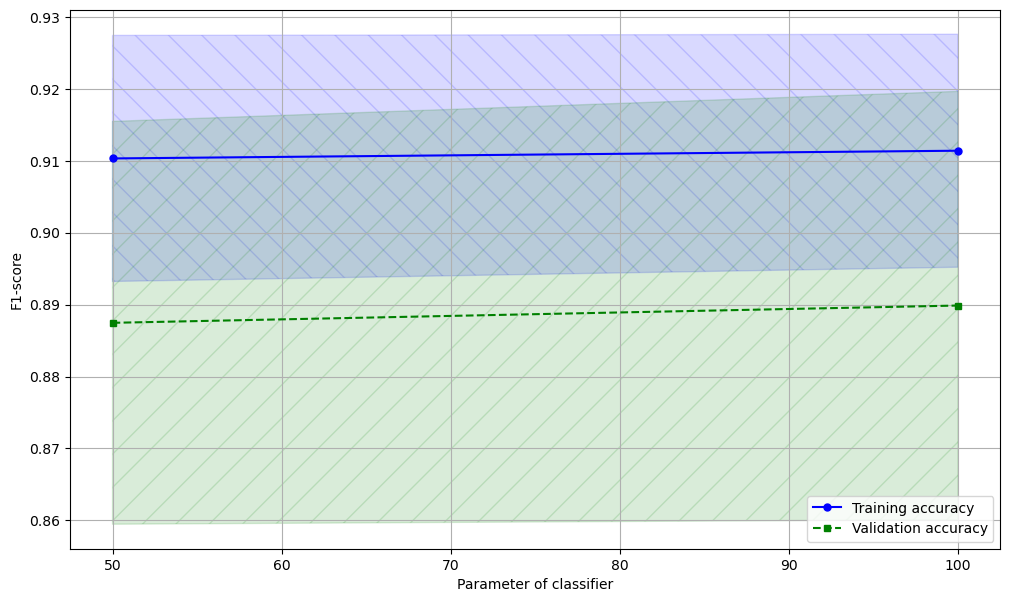

In [42]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axB = fig.add_subplot()
axB.plot(range_classifier, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

axB.fill_between(range_classifier,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue',
                 hatch='\\')

axB.plot(range_classifier, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

axB.fill_between(range_classifier,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axB.grid()
axB.set_xlabel('Parameter of classifier')
axB.set_ylabel('F1-score')
axB.legend(loc='lower right')
axB.set_autoscale_on(True)

In [77]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('smote', SMOTE(random_state=42)),
    ('dim_reduction', SFS(Perceptron(), k_features=(20), scoring='f1')),
    ('classifier', Perceptron())
])

params = {
    'dim_reduction__k_features': [15, 20 ],
    'classifier__max_iter': [1, 5, 10, 20],
    'classifier__eta0' : loguniform(0.001, 1),
    'classifier__class_weight' : [None, "balanced"]
}

rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1',
    random_state=33,
    n_jobs=-1,
    error_score= 'raise',
    verbose=1
)



In [78]:
rs_best.fit(X_train, y_train)
y_pred = rs_best.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"Best F1 score: {rs_best.best_score_}")
print(f"Best parameters: {rs_best.best_params_}")
print(f"F1 score on test set: {f1}")

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Best F1 score: 0.801360186164415
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__eta0': 0.06900318309882239, 'classifier__max_iter': 10, 'dim_reduction__k_features': 20}
F1 score on test set: 0.9115281501340482


In [97]:
rs_best.fit(X_train, y_train)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('1',
                                                                               Pipeline(steps=[('imp',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Victim.Age',
                                                                                'Perpetrator.Age']),
                                                                              ('2',
                                                                               Pipeline(steps=[('1',
                                                                                                SimpleImputer(strategy='mo...
                                                                        k_features=20,
                                                                        scoring='f1')),
                                             ('classifier', Perceptron())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EC10B65040>,
                                        'classifier__max_iter': [1, 5, 10, 20],
                                        'dim_reduction__k_features': [15, 20]},
                   random_state=33, scoring='f1', verbose=1)

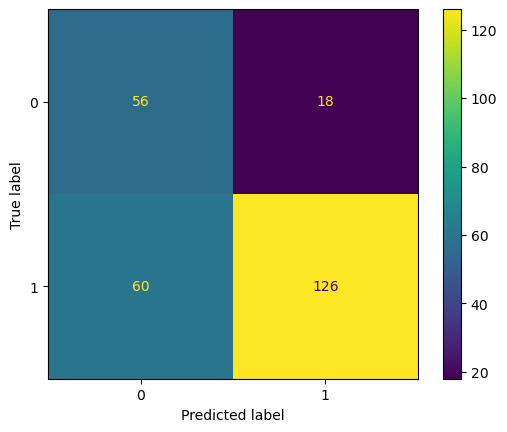

In [99]:
plot_confusion_matrix(rs_best, X_test, y_test)
plt.show()

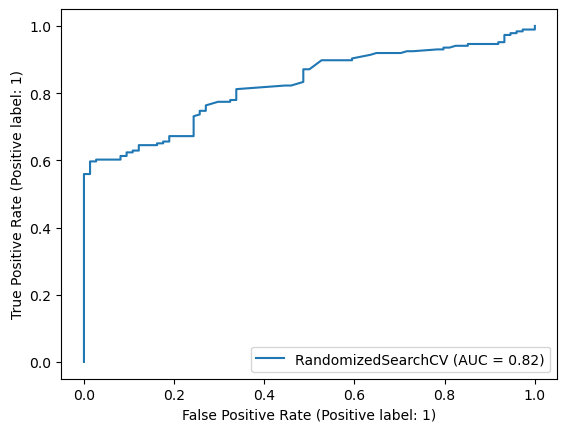

In [101]:
plot_roc_curve(rs_best, X_test, y_test)
plt.show()

In [98]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('1',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Victim.Age',
                                                   'Perpetrator.Age']),
                                                 ('2',
                                                  Pipeline(steps=[('1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Agency.Type', 'Crime.Type',
                                                   'Victim.Sex', 'Victim.Race',
                                                   'Perpetrator.Sex',
                                                   'Perpetrator.Race', 'City',
                                                   'Weapon', 'Relationship',
                                                   'Month',
                                                   'Victim.Count'])])),
                ('smote', SMOTE(random_state=42)),
                ('dim_reduction',
                 SequentialFeatureSelector(estimator=Perceptron(),
                                           k_features=(15, 15), scoring='f1')),
                ('classifier',
                 Perceptron(class_weight='balanced', eta0=0.10998980046726198,
                            max_iter=20))])

In [102]:
cls = rs_best.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 2,
                                                       n_jobs = -1,
                                                       shuffle = True, #shuffle the data before splitting
                                                       scoring = 'f1',
                                                       verbose = 1 #display the output
                                        )

[learning_curve] Training set sizes: [  5  51 103 155 207 259 310 362 414 466 518]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   10.5s finished


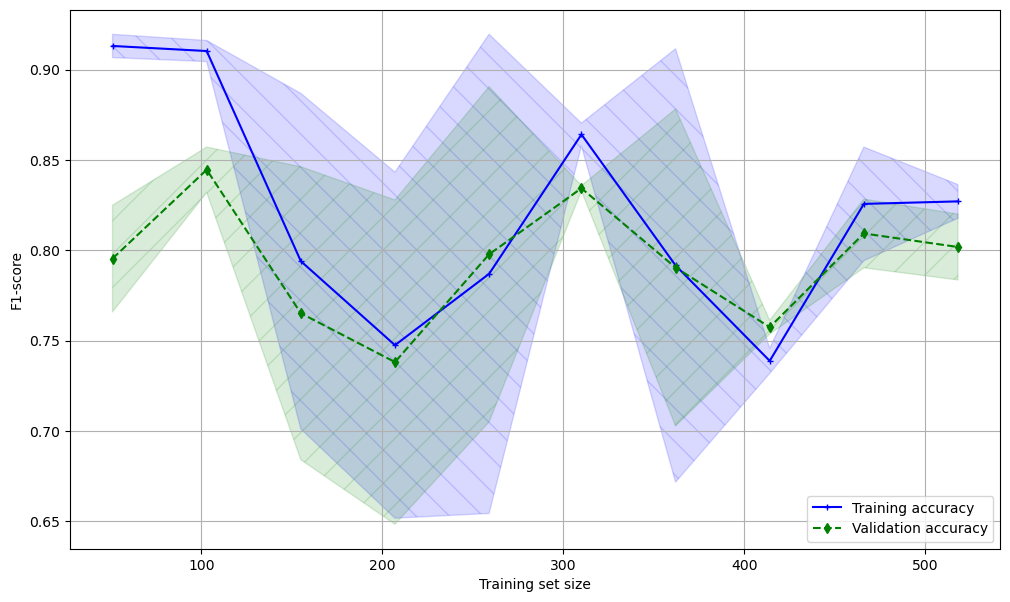

In [103]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axA = fig.add_subplot()

axA.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

axA.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue', 
                 hatch='\\')

axA.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

axA.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axA.grid()
axA.set_xlabel('Training set size')
axA.set_ylabel('F1-score')
axA.legend(loc='lower right')
axA.set_autoscale_on(True)

In [104]:
range_classifier = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=range_classifier, 
        param_name='classifier__eta0',
        cv=5, 
        n_jobs=-1, 
        scoring='f1',
        error_score= 'raise',
        verbose=1 #to display the output
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   35.4s finished


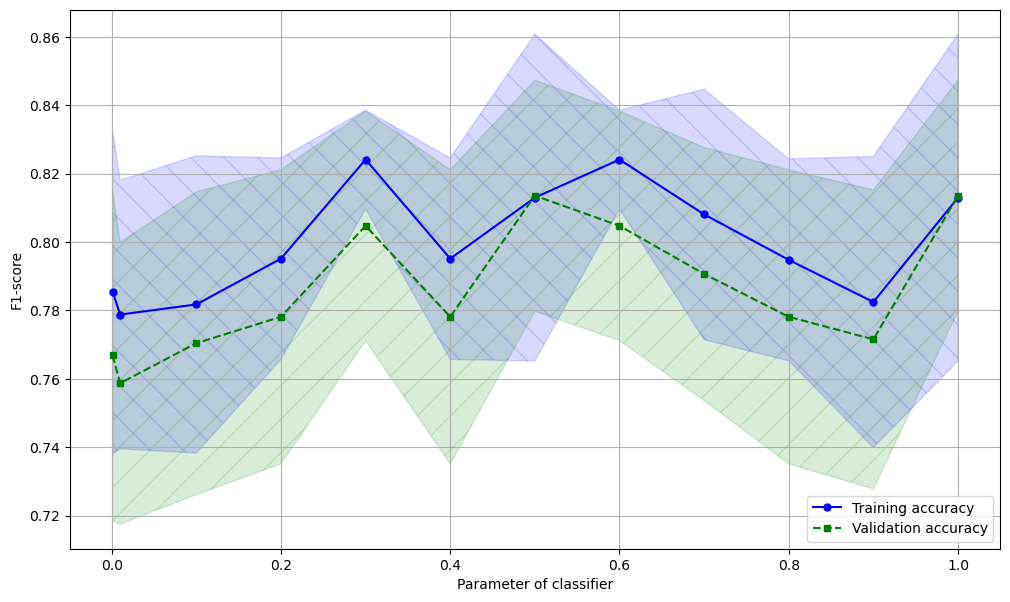

In [105]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
axB = fig.add_subplot()
axB.plot(range_classifier, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

axB.fill_between(range_classifier,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, 
                 color='blue',
                 hatch='\\')

axB.plot(range_classifier, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

axB.fill_between(range_classifier,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green',
                 hatch = "/")

axB.grid()
axB.set_xlabel('Parameter of classifier')
axB.set_ylabel('F1-score')
axB.legend(loc='lower right')
axB.set_autoscale_on(True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=988de652-6763-480c-b033-cc5fe8c27aae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>